In [333]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.linalg import expm
import time
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'

In [334]:
# シミュレーションパラメータ
total_time = 2*np.pi # ns
n_steps = 1000 #時間スライス数
dt = total_time / n_steps #スライス幅

# パウリ行列
sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)
identity = np.eye(2, dtype=np.complex128)

# 状態
down = np.array([[0], [1]], dtype=np.complex128)  # |1⟩
up = np.array([[1], [0]], dtype=np.complex128)    # |0⟩

# ハミルトニアン
H_controls = [sx, sy, sz]
H_drift =  np.zeros((2, 2), dtype=np.complex128)

In [335]:
# シミュレーション関数の定義

initial_state = up
target_state = down

# コスト関数
def fidelity(arbitrary_state: np.ndarray, target_state: np.ndarray):
    """
    コスト関数を計算する
    
    """
    F = np.abs(target_state.conj().T @ arbitrary_state)[0, 0]**2
    return F

# 順伝播
def forward_propagation(pulses: list, initial_state: np.ndarray) -> list:
    """
    パルス列(pulse)と初期状態(initial_state)を受け取り、順伝播を計算する
    
    Parameters
    ----------
    pulses : list
        各時間ステップでの制御パルスの振幅値のリスト。
        pulses[t][k]は時間tでのk番目の制御ハミルトニアンに対する振幅。
    initial_state : np.ndarray
        系の初期状態ベクトル。
        
    Returns
    -------
    state_history : list
        各時間ステップでの量子状態のリスト。
    U_list : list
        各時間ステップでのユニタリ演算子のリスト。
    """
    state_history = [initial_state.copy()]
    U_list = []
    
    # ユニタリの計算
    for t in range(n_steps): # 各スライス
        H = H_drift.copy()

        for k in range(len(H_controls)): # 各制御ハミルトニアン
            #print(t,k)
            H += pulses[k][t] * H_controls[k] # t地点のH(t)を計算

        
        U = expm(-1j * dt * H) # propagator：U(t)を計算
        

        # メモリに保存
        U_list.append(U)
        state_history.append(U @ state_history[-1]) # 状態の更新

    return state_history, U_list

def back_propagation(target_state: np.ndarray, U_list: list) -> list:
    """
    ターゲット状態と各時間ステップでのユニタリ演算子を用いて逆伝播を計算する
    
    Parameters
    ----------
    target_state : np.ndarray
        目標とする量子状態ベクトル。
    U_list : list
        各時間ステップでのユニタリ演算子のリスト。
        
    Returns
    -------
    phi : list
        各時間ステップでの随伴状態のリスト。逆伝播により計算される。
        phi[t]は時間tでの随伴状態を表す。
    """
    phi = [None] * (n_steps + 1)
    phi[-1] = target_state.copy() # 最終時刻の状態をコピー

    for t in reversed(range(n_steps)): # 逆伝播を計算
        phi[t] = U_list[t].conj().T @ phi[t+1]

    return phi

def grape_cost_and_grad(x: list):
    """
    GRAPEアルゴリズムにおけるコスト関数とその勾配を計算する
    
    Parameters
    ----------
    """
    # パルス列を [n_controls] x [n_steps] の行列に変換
    pulses = [x[i*n_steps:(i+1)*n_steps] for i in range(len(H_controls))]

    # 順伝播
    state_history, U_list = forward_propagation(pulses, initial_state)
    final_state = state_history[-1]

    # フィデリティ
    F = fidelity(state_history[-1], target_state)

    # 初期共役状態の計算
    overlap = (target_state.conj().T @ final_state)[0,0]
    chi_T = overlap * target_state # 2x1ベクトル
    
    # 逆伝播
    chi = back_propagation(chi_T, U_list)

    # 勾配の計算
    grad = np.zeros_like(x)
    for k in range(len(H_controls)):
        for t in range(n_steps):
            # ∂H/∂u_{i,k} = H_controls[i]
            bracket = chi[t+1].conj().T @ (-1j * dt * H_controls[k]) @ state_history[t]
            # 虚部を取り出す
            grad[k*n_steps + t] = -2 * np.imag(bracket)[0, 0]

    return -F, -grad

In [336]:
# Util関数

history = []
def callback_func(x):

    # パルス列を [n_controls] x [n_steps] の行列に変換
    pulses = [x[i*n_steps:(i+1)*n_steps] for i in range(len(H_controls))]

    # 状態を発展
    final_state = forward_propagation(pulses, initial_state)[0][-1]

    # 忠実度を計算
    F = fidelity(final_state, target_state)
    history.append(F)

    return False

In [337]:
# シミュレーションの実行
# 初期パルス
np.random.seed(0)
initial_pulses_flat = 0.2 * np.random.randn(3 * n_steps)

# パルス制約
pulse_bounds = [(-1.0, 1.0)] * (3 * n_steps)

print("最適化を実行...")
start_time = time.time()
result = minimize(
    grape_cost_and_grad,
    initial_pulses_flat,
    method="L-BFGS-B",
    jac=True,
    bounds=pulse_bounds,
    callback=callback_func,
    options={'maxiter':500, 'disp':True, 'gtol':1e-6}
)
end_time = time.time()
print(f"最適化経過時間： {end_time - start_time:.2f}秒")

最適化を実行...
最適化経過時間： 0.58秒


初期忠実度: 0.003406
最終忠実度: 0.428598
改善率: 42.52%


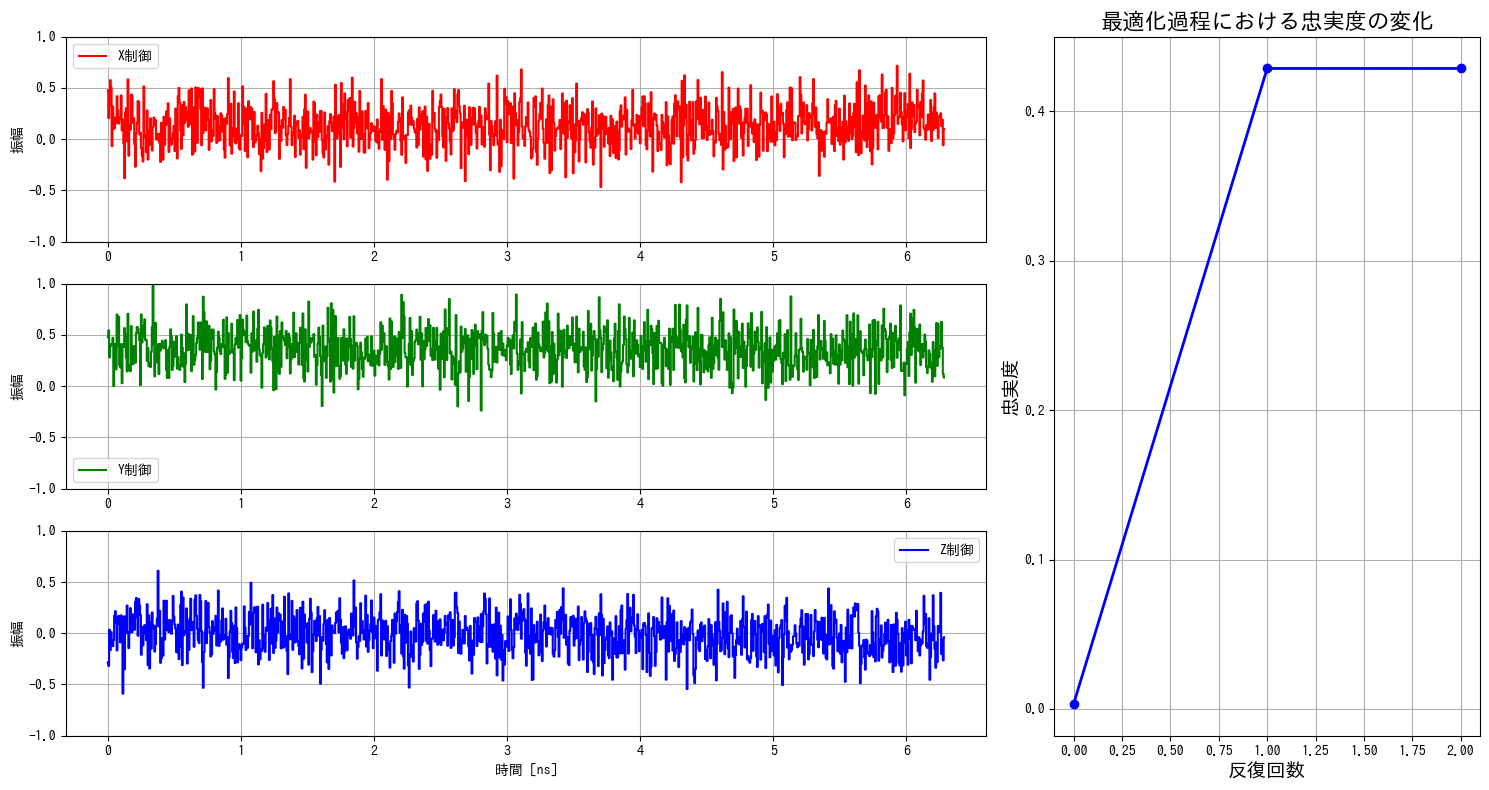

In [338]:
# 最適化されたパルスを取得
optimized_pulses = [
    result.x[:n_steps],
    result.x[n_steps:2*n_steps],
    result.x[2*n_steps:3*n_steps]
]

# 初期値から最終値までの改善を表示
initial_fidelity = history[0] if history else 0
final_fidelity = history[-1] if history else 0
print(f"初期忠実度: {initial_fidelity:.6f}")
print(f"最終忠実度: {final_fidelity:.6f}")
print(f"改善率: {(final_fidelity - initial_fidelity) * 100:.2f}%")

# 最適化されたパルスと忠実度履歴を表示
time_grid = np.linspace(0, total_time, n_steps)
fig = plt.figure(figsize=(15,8))

# 左側に最適化されたパルスのサブプロット（3行1列、2カラム分の幅）
ax1 = plt.subplot(3, 3, (1, 2))  # 1行目、1-2列
ax1.step(time_grid, optimized_pulses[0], 'r-', where='mid', label='X制御')
ax1.set_ylabel('振幅')
ax1.set_ylim(pulse_bounds[0])
ax1.legend()
ax1.grid(True)

ax2 = plt.subplot(3, 3, (4, 5))  # 2行目、1-2列
ax2.step(time_grid, optimized_pulses[1], 'g-', where='mid', label='Y制御')
ax2.set_ylabel('振幅')
ax2.set_ylim(pulse_bounds[0])
ax2.legend()
ax2.grid(True)

ax3 = plt.subplot(3, 3, (7, 8))  # 3行目、1-2列
ax3.step(time_grid, optimized_pulses[2], 'b-', where='mid', label='Z制御')
ax3.set_xlabel('時間 [ns]')
ax3.set_ylabel('振幅')
ax3.set_ylim(pulse_bounds[0])
ax3.legend()
ax3.grid(True)

# 右側に忠実度履歴のサブプロット（1行1列）
ax4 = plt.subplot(1, 3, 3)
ax4.plot(history, 'o-b', linewidth=2)
ax4.set_xlabel('反復回数', fontsize=14)
ax4.set_ylabel('忠実度', fontsize=14)
ax4.set_title('最適化過程における忠実度の変化', fontsize=16)
ax4.grid(True)

plt.tight_layout()
plt.show()

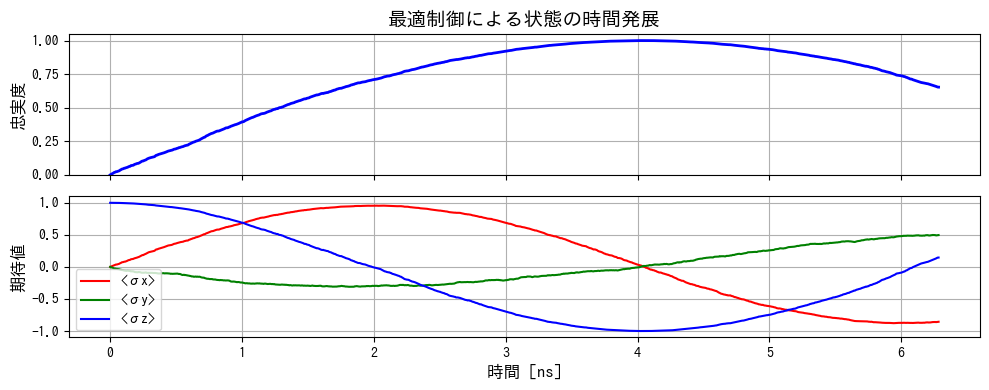

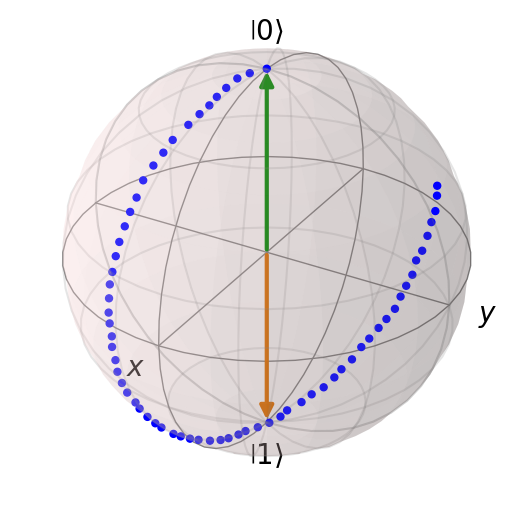

In [339]:
import qutip as qt
tlist = np.linspace(0, total_time, n_steps)

# QuTiPでスピン演算子を定義
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
si = qt.identity(2)

# 状態を定義
qutip_down = qt.basis(2, 1)  # |1⟩ = (0, 1)
qutip_up = qt.basis(2, 0)    # |0⟩ = (1, 0)

qutip_initial_state=qutip_up
qutip_target_state=qutip_down

# 最適化されたパルスを使用（前のセルの結果を使用）
# optimized_pulsesはすでにSciPyの最適化結果から取得済みと仮定

# コントロールハミルトニアンのリスト
H_controls = [sx, sy, sz]
H_drift = si * 0 # ドリフトハミルトニアン（ここではゼロ）

# 時間依存ハミルトニアンの定義
def H_t(t, args):
    # 時間tでのパルス値を補間
    idx = int(t / total_time * (n_steps - 1))
    idx = min(idx, n_steps - 1)  # 範囲を超えないように
    
    # ハミルトニアンを構築
    H = H_drift.copy()
    for i, H_control in enumerate(H_controls):
        H += optimized_pulses[i][idx] * H_control
    
    # QuTiPのQobj型を返す必要がある
    return qt.Qobj(H)

# 時間発展の計算
result = qt.mesolve(H_t, qutip_initial_state, tlist, [], [])

# 目標状態との忠実度を計算
fidelities = []
for state in result.states:
    fidelity = qt.fidelity(state, qutip_target_state)
    fidelities.append(fidelity)

# スピン期待値と忠実度の時間変化をサブプロットで表示
fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# 忠実度の時間変化（上のサブプロット）
axs[0].plot(tlist, fidelities, 'b-', linewidth=2)
axs[0].set_ylabel('忠実度', fontsize=12)
axs[0].set_title('最適制御による状態の時間発展', fontsize=14)
axs[0].grid(True)
axs[0].set_ylim(0, 1.05)

# スピン期待値の計算
sx_exp = [qt.expect(sx, state) for state in result.states]
sy_exp = [qt.expect(sy, state) for state in result.states]
sz_exp = [qt.expect(sz, state) for state in result.states]

# スピン期待値の時間変化（下のサブプロット）
axs[1].plot(tlist, sx_exp, 'r-', label='<σx>')
axs[1].plot(tlist, sy_exp, 'g-', label='<σy>')
axs[1].plot(tlist, sz_exp, 'b-', label='<σz>')
axs[1].set_xlabel('時間 [ns]', fontsize=12)
axs[1].set_ylabel('期待値', fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(True)

plt.tight_layout()
plt.show()

# ブロッホ球上での状態の可視化
b = qt.Bloch()
# 状態ベクトルを3次元座標（ブロッホ球上の点）に変換
x_points = []
y_points = []
z_points = []
for state in result.states[::15]:  # 表示を見やすくするために間引く
    # 各状態のスピン期待値を計算して3次元座標として追加
    x_points.append(qt.expect(sx, state))
    y_points.append(qt.expect(sy, state))
    z_points.append(qt.expect(sz, state))

# 点としてブロッホ球に追加（正しい形式：[x,y,z]の配列）
points = np.array([x_points, y_points, z_points])
b.add_points(points)
b.add_states([qutip_initial_state])  # 初期状態
b.add_states([qutip_target_state])  # 目標状態
b.show()
